In [205]:
! python -m pip install pyaudio

In [206]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
import string
import math
import scipy.signal as sgn

import pyaudio
import wave

from helpers import *

In [280]:
# Constants

Fs = 16000 # sampling freqency
TWOPI = 2 * np.pi
T=1

freq_shift = 0 # will be set to 1000 [Hz] if the channel is between 2000 and 3000 Hz, and left so if 1000->2000

# Speaker's noise range detection

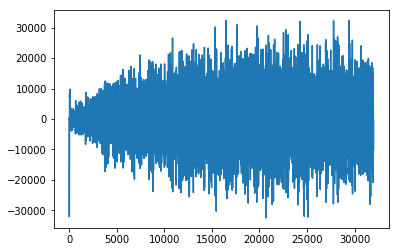

In [254]:
# Record initial noise !!

CHUNKSIZE = 32000 # 2 seconds

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=Fs, input=True, frames_per_buffer=CHUNKSIZE)

# do this as long as you want fresh samples
data = stream.read(CHUNKSIZE)
numpydata = np.fromstring(data, dtype=np.int16)

noise = numpydata/1

# plot data
plt.plot(noise)
plt.show()

# close stream
stream.stop_stream()
stream.close()
p.terminate()

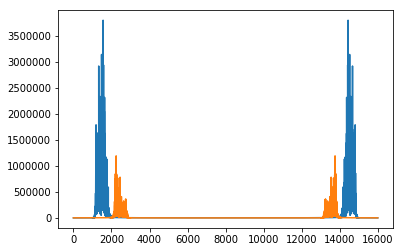

In [402]:
# Check presence of silence between 1kHz and 2kHz
noise12 = butter_bandpass_filter(noise, 1200, 1800, Fs, order=10)
amplitude12 = np.mean(noise12)

# Check presence of silence between 2kHz and 3kHz
noise23 = butter_bandpass_filter(noise, 2200, 2800, Fs, order=10)
amplitude23 = np.mean(noise23)

# Plot
plt.plot(abs(np.fft.fft(noise12, Fs)))
plt.plot(abs(np.fft.fft(noise23, Fs)))
plt.show()

In [288]:
NOISE_RANGE=0 
if (abs(amplitude12) < abs(amplitude23)):
    NOISE_RANGE=1
else:
    NOISE_RANGE=2

if(NOISE_RANGE==2):
    freq_shift=1000
    
NOISE_RANGE # =1 if channel is free between 1kHz and 2kHz, =2 if 2kHz to 3kHz

2

# Pulse

In [282]:
my_alphabet = list(' ' + string.printable) #our alphabet

#transforms a character from our alphabet to its binary representation
def toBinary(c):
    my_index = my_alphabet.index(c)
    toBinary = bin(my_index)
    return toBinary[2:] # we remove the header "0b"

In [405]:
number_bits = int(math.ceil(np.log2(len(my_alphabet)))) # the number of bits we require to represent our alphabet
my_base = np.linspace(1000, 2000, num= math.ceil(number_bits+2 )) # +2 because we dont need the borders (1000 and 2000)
base_distance = my_base[1] - my_base[0] # distance between 2 waves freqs

In [349]:
my_base

array([ 1000.,  1125.,  1250.,  1375.,  1500.,  1625.,  1750.,  1875.,
        2000.])

In [318]:
#adds to x a wave of frequency f
def wave(x,f,n):
    x += np.sin(TWOPI * (float(f + freq_shift)/Fs) * n) # If freq_shift=1000, all sines are shifted to the 1kHz-2kHz range.
    return x

#transforms a character from our alphabet to a distinct wave
def toWave(c):
    my_bin = toBinary(c)
    x = np.zeros(int(T * Fs))
    n = np.arange(len(x))
    for i in range(len(my_bin) -1, -1, -1):
        if(int(my_bin[i])):
            f = my_base[len(my_bin) - i] # because of the binary base
            x = wave(x, f, n)
    return x

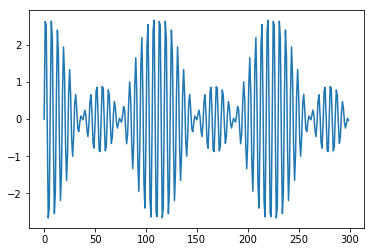

In [319]:
#You can test every character here (example with 'D')

x = toWave('T')
# the plot
plt.plot(x[0:300])
plt.show()

# we can play it:
IPython.display.Audio(x, rate=Fs)

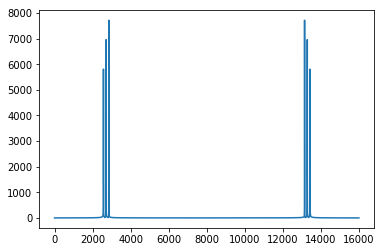

In [320]:
X = np.fft.fft(x, Fs)
plt.plot(np.abs(X))
plt.show()

On ferait peut etre mieux de générer les son avec le raised cosine aussi

# Emitter

In [85]:
# open the message file
my_text = open('message.txt', 'r')
my_message = my_text.read()
my_text.close

<function TextIOWrapper.close>

In [86]:
# array of our waves
my_message_waves = []
for i in range(len(my_message)):
    my_message_waves.append(toWave(my_message[i]))

In [87]:
# we generate the wave to be sent
to_be_sent = my_message_waves[0]
for i in range(1, len(my_message_waves)):
    to_be_sent = np.concatenate((to_be_sent, my_message_waves[i]))

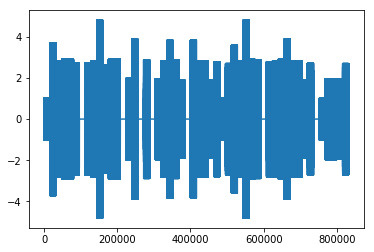

In [88]:
plt.plot(to_be_sent)
plt.show()

# we can play it:
IPython.display.Audio(to_be_sent, rate=Fs)

# Reciever's bandpass filter

In [406]:
# Toy white noise
mean = 0
std = 1 
num_samples = 64000 # 4 seconds
raw_signal = np.random.normal(mean, std, size=num_samples)

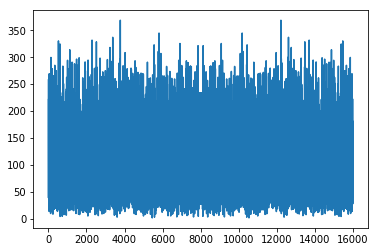

In [407]:
plt.plot(abs(np.fft.fft(raw_signal, Fs)))

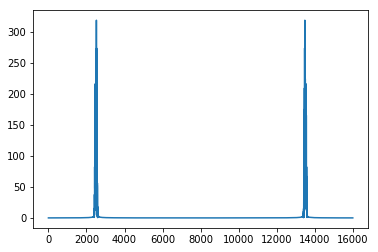

In [408]:
# rec_signal is an array of 7 signals corresponding to the filtered 7 frenquencies we may send

rec_signal = []

for i in range (1, 8):
    rec_signal.append(butter_bandpass_filter(raw_signal, my_base[i]+freq_shift-base_distance/2, my_base[i]+freq_shift+base_distance/2, Fs, order=8))
    
plt.plot(abs(np.fft.fft(rec_signal[3], Fs)))

# Matched filter cross-correlation (1 per frequency)

In [195]:
#original sent wave (3 freqs : 1000, 1200, 1400)
sig = raised_cosine(1000, 1, 16000, beta=0.5) + raised_cosine(1200, 1, 16000, beta=0.5) + raised_cosine(1400, 1, 16000, beta=0.5)

# noisy signal
sig_noise = sig + np.random.randn(len(sig)) # noiiiiiise

# freqs we wanna check if present or not in the sent wave
sig1 = raised_cosine(1000, 1, 16000, beta=0.5)
sig2 = raised_cosine(1300, 1, 16000, beta=0.5)

# filter signal to only keep freq to be checked
sig_filtered1 = butter_bandpass_filter(sig, 950, 1050, Fs, order=5) # check if 1000 present
sig_filtered2 = butter_bandpass_filter(sig, 1250, 1350, Fs, order=5) # check if 1300 present

# x-corr to see if present in the signal
corr1 = sgn.correlate(sig_filtered1, sig1, mode='same') # recovered wave !!!
corr2 = sgn.correlate(sig_filtered2, sig2, mode='same') # not recovered wave !!!

In [196]:
IPython.display.Audio(sig, rate=Fs)

In [197]:
IPython.display.Audio(sig_noise, rate=Fs)

In [198]:
IPython.display.Audio(sig_filtered1, rate=Fs)

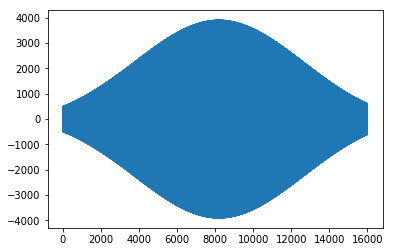

In [199]:
plt.plot(corr1)

In [200]:
IPython.display.Audio(sig_filtered2, rate=Fs)

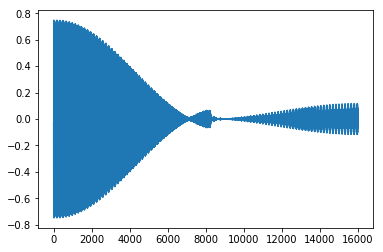

In [201]:
plt.plot(corr2)

In [ ]:
ffff